## MOM025 Wed Poly wind isolation

In [3]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage




Populating the interactive namespace from numpy and matplotlib


In [4]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [5]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.9.6


In [6]:
NYFCntrlDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_wpm2/'

WombatCntrlDir = '/g/data1/v45/mtc599/mom5/jun16y/OUTPUT/'
WombatPertDir = '/g/data1/v45/mtc599/mom5/jun16y/OUTPUT/'


#ExpDirs=[CntrlDir, PertDir, NYFPertDir]
#print ExpDirs

In [5]:
#plot wind stress
Ocean_File = os.path.join(NYFCntrlDir,'output501/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.tau_x.shape
cntrl_tx=ff.tau_x.load()

Ocean_File = os.path.join(NYFPertDir,'output501/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.tau_x.shape
pert_tx=ff.tau_x.load()

/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/output501/ocean.nc
(1, 1080, 1440)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_wpm2/output501/ocean.nc
(1, 1080, 1440)


bounds lon1 lon2 lat1 lat2 [-99.875] [ 50.125] [-79.91541635] [-49.9789212]


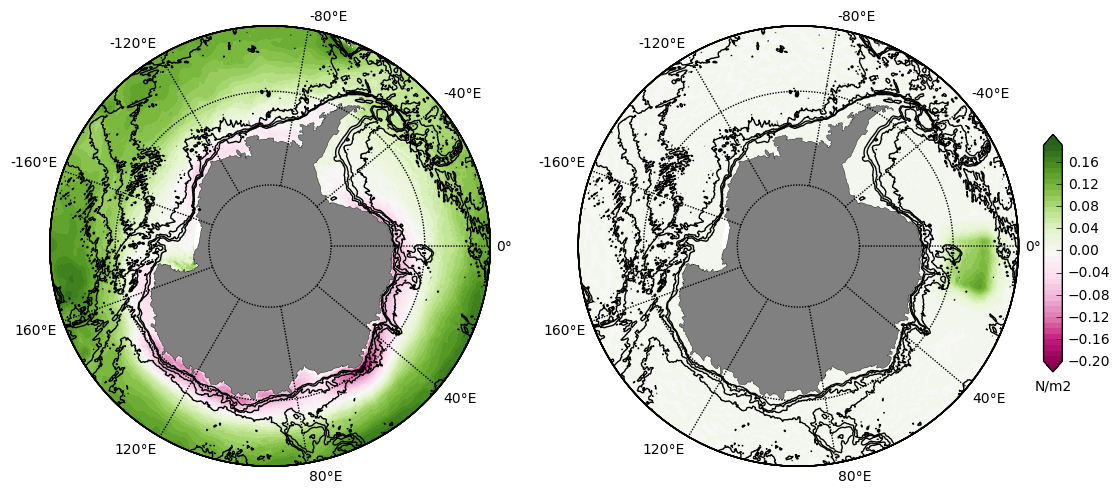

In [93]:
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>-80)# and lat<-45)
jj2=np.argwhere(yt_ocean>-50)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=jj2[0]
#jj2=jj2[0]

print "bounds lon1 lon2 lat1 lat2", xt_ocean[ii1], xt_ocean[ii2], yt_ocean[jj1], yt_ocean[jj2]

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-.2,.2,.01)

plt.subplot(1,2,1)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl_tx[0], cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
#plt.title('Control Zonal Wind Stress')

#clev = np.arange(-.1,.1,.01)
anom=pert_tx[0]-cntrl_tx[0]

plt.subplot(1,2,2)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,anom, cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
#plt.title('Zonal Wind Stress Anomaly')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('N/m2')
plt.savefig('wpm2_tx.pdf')
plt.savefig('wpm2_tx.png',dpi=220)


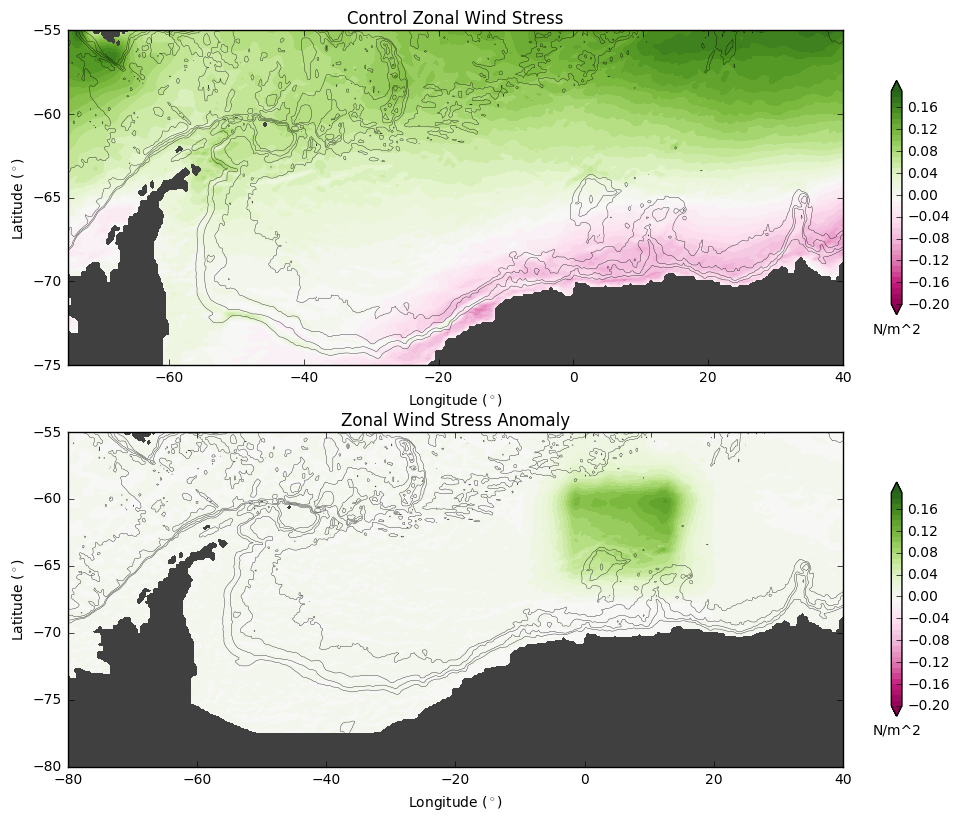

In [56]:
clev = np.arange(-.2,.2,.01)
clev3 = np.arange(0,5000,1000)

plt.subplot(211)
plt.gca().patch.set_color('.25')
clev = np.arange(-.2,.2,.01)
ax=plt.contourf(xt_ocean,yt_ocean,masked_array,cmap=cmap,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m^2')
clev3 = np.arange(0,5000,1000)
plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-55))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-75,40])
plt.title('Control Zonal Wind Stress')

plt.subplot(212)
plt.gca().patch.set_color('.25')
plt.contourf(xt_ocean,yt_ocean,anom,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m^2')
clev3 = np.arange(0,5000,1000)
plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-80,-55))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-80,40])
plt.title('Zonal Wind Stress Anomaly')



In [64]:
#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'output501/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
nyf_cn=ff.CN.sum('ct').load()
print nyf_cn.shape

Ocean_File = os.path.join(NYFPertDir,'output*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
pert_cn=ff.CN.sum('ct').load()
print pert_cn.shape

print nyf_cn.shape
print pert_cn.shape
cn = np.concatenate((nyf_cn[0:12,:],pert_cn),axis=0)
print cn.shape


(12, 5, 1080, 1440)
(12, 1080, 1440)
(156, 5, 1080, 1440)
(156, 1080, 1440)
(12, 1080, 1440)
(156, 1080, 1440)
(168, 1080, 1440)


[]

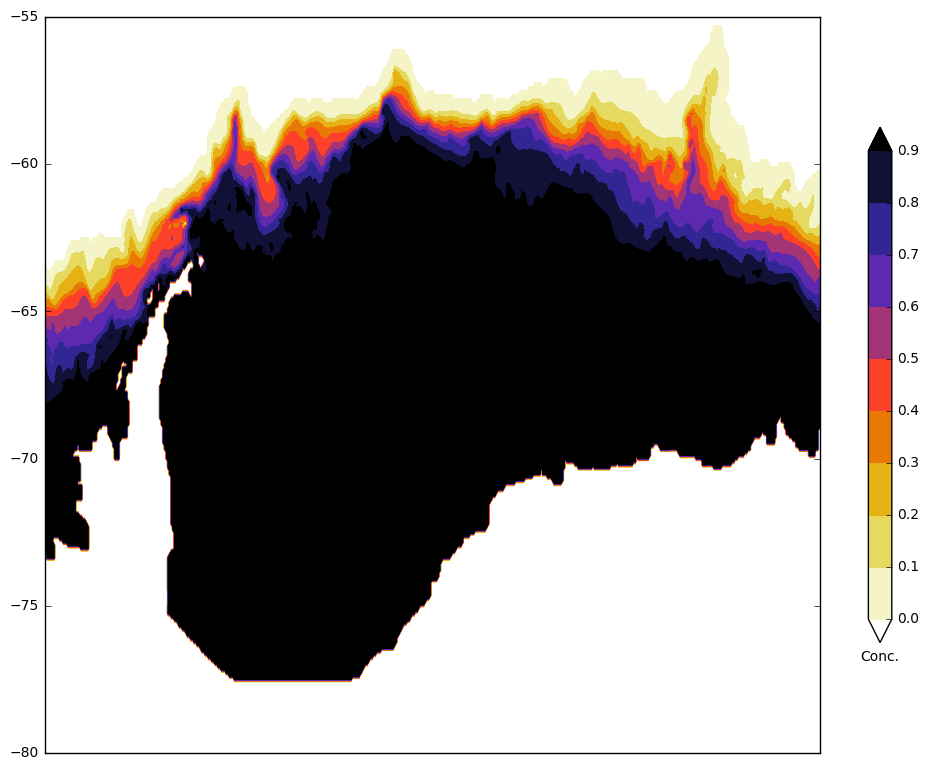

In [84]:
clev = np.arange(0,1,.1)

plt.subplot(111)
plt.gca().patch.set_color('.25')
plt.contourf(xt_ocean,yt_ocean,cn[5,:,:],cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Conc.')
#clev3 = np.arange(0,5000,1000)
#plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-80,-55))
#plt.xlabel('Longitude ($^\circ$)')
#plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-80,40])
#plt.title('Zonal Wind Stress Anomaly')
#plt.gca()axes.get_xaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_ticks([])

['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']


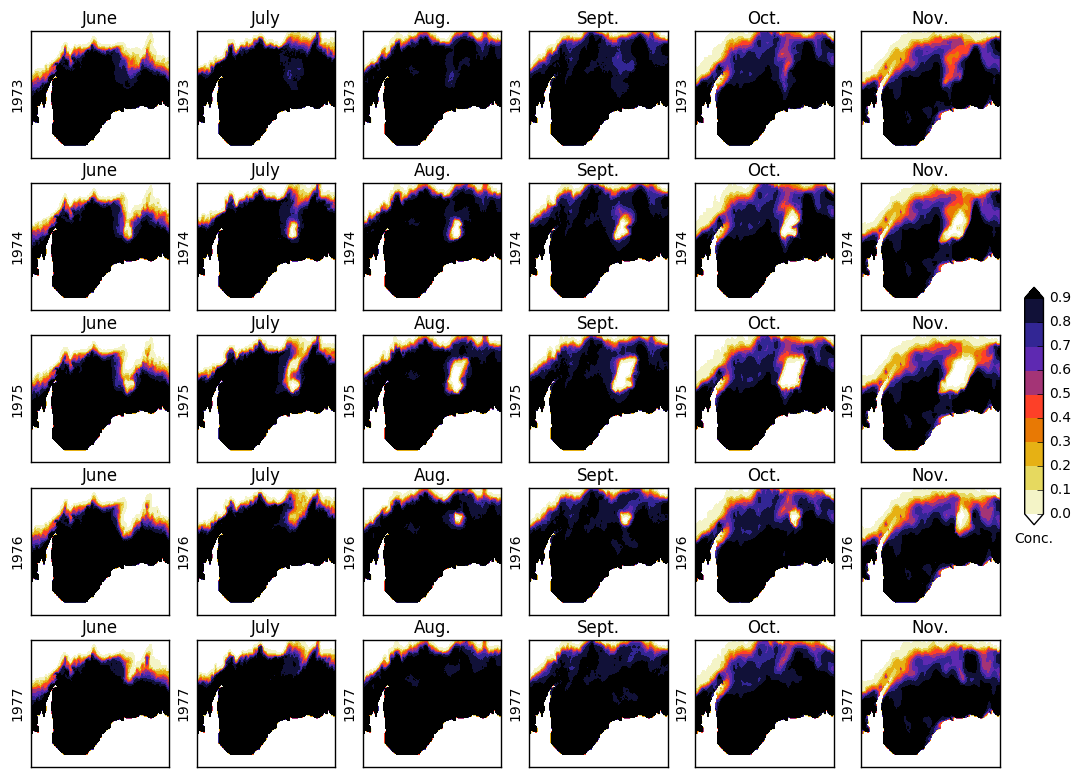

In [91]:
clev = np.arange(-.2,.2,.01)
clev3 = np.arange(0,5000,1000)

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=['1973','1974','1975','1976','1977']
print tits

ii=0
for yr in range(0,5):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(5,6,ii+1)
        plt.gca().patch.set_color('.25')
        p1=plt.contourf(xt_ocean,yt_ocean,pert_cn[yr*12+i,:,:],cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-55))
        #plt.xlabel('Longitude ($^\circ$)')
        plt.ylabel(yrs[yr])
        plt.xlim([-80,40])
        plt.title(tits[i-5])     
        plt.gca().axes.get_xaxis().set_ticks([])
        plt.gca().axes.get_yaxis().set_ticks([])
        
        ii+=1

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')
plt.savefig('wpm2_cn.pdf')
plt.savefig('wpm2_cn.png',dpi=220)

## Calc the GMOC from ty_trans_rho 

In [33]:
Ocean_File = os.path.join(NYFPertDir,'output*/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans_rho.shape

pert_gmoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print pert_gmoc.shape

of=os.path.join(NYFPertDir,'gmoc_rho.npy')
a=np.save(of,pert_gmoc)



/g/data1/v45/pas561/mom/archive/gfdl_nyf_wpm2/output*/ocean.nc
(13, 80, 1080, 1440)
(13, 80, 1080)


In [34]:
Ocean_File = os.path.join(NYFCntrlDir,'output5*/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans_rho.shape

cntrl_gmoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print cntrl_gmoc.shape

of=os.path.join(NYFCntrlDir,'gmoc_rho.npy')
a=np.save(of,cntrl_gmoc)


/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/output5*/ocean.nc
(20, 80, 1080, 1440)
(20, 80, 1080)


In [35]:
#load gmoc in rho space
of=os.path.join(NYFPertDir,'gmoc_rho.npy')
pert_gmoc=np.load(of)
print pert_gmoc.shape

#of=os.path.join(NYFCntrlDir,'cntrl_gmocs.npy')
of=os.path.join(NYFCntrlDir,'gmoc_rho.npy')
cntrl_gmoc=np.load(of)
print cntrl_gmoc.shape



(13, 80, 1080)
(20, 80, 1080)


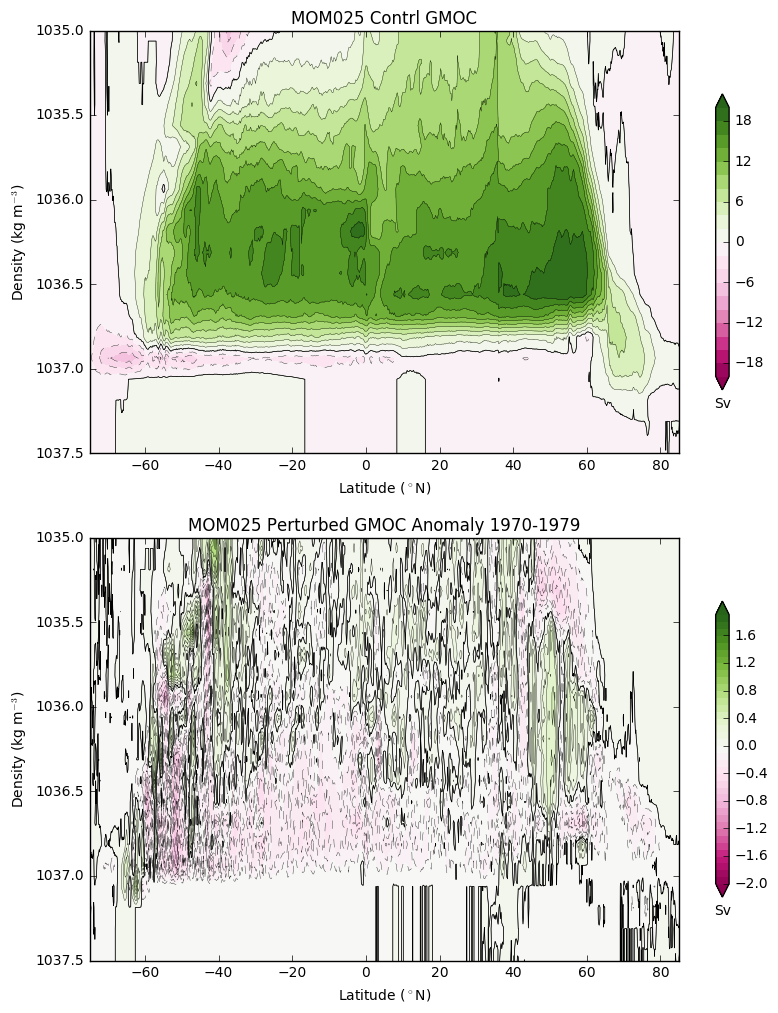

In [37]:
#plot gmoc in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,22,2)

t1=0
t2=5

plt.subplot(211)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='MOM025 Contrl GMOC'
plt.title(tit)

clev = np.arange(-2,2,.1)

plt.subplot(212)
plt.contourf(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='MOM025 Perturbed GMOC Anomaly 1970-1979'
plt.title(tit)


(50,)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: converting an array with ndim > 0 to an

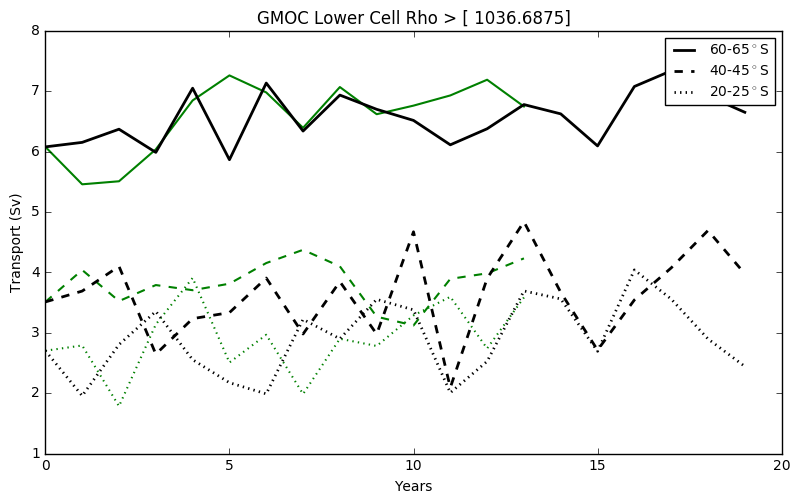

In [11]:
#plot time series of AABW
T=np.arange(50)
print T.shape

# do lower cell average between lats 60-65S
j1=np.argwhere(yt_ocean<-65)
j2=np.argwhere(yt_ocean<-60)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(potrho<1036.75)
z1=z1[-1]

lc_cntrl60_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl60_psj_bar = np.mean(lc_cntrl60_psj,2)
lc_cntrl60_psj_ts = -np.min(lc_cntrl60_psj_bar,1)

lc_pert60_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert60_psj_bar = np.mean(lc_pert60_psj,2)
lc_pert60_psj_ts = -np.min(lc_pert60_psj_bar,1)
lc_pert60_psj_ts=np.insert(lc_pert60_psj_ts,0,lc_cntrl60_psj_ts[0])

# do lower cell average between lats 40-45S
j1=np.argwhere(yt_ocean<-45)
j2=np.argwhere(yt_ocean<-40)
j1=j1[-1]
j2=j2[-1]

lc_cntrl40_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl40_psj_bar = np.mean(lc_cntrl40_psj,2)
lc_cntrl40_psj_ts = -np.min(lc_cntrl40_psj_bar,1)

lc_pert40_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert40_psj_bar = np.mean(lc_pert40_psj,2)
lc_pert40_psj_ts = -np.min(lc_pert40_psj_bar,1)
lc_pert40_psj_ts=np.insert(lc_pert40_psj_ts,0,lc_cntrl40_psj_ts[0])

# do lower cell average between lats 20-25S
j1=np.argwhere(yt_ocean<-25)
j2=np.argwhere(yt_ocean<-20)
j1=j1[-1]
j2=j2[-1]

lc_cntrl20_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl20_psj_bar = np.mean(lc_cntrl20_psj,2)
lc_cntrl20_psj_ts = -np.min(lc_cntrl20_psj_bar,1)

lc_pert20_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert20_psj_bar = np.mean(lc_pert20_psj,2)
lc_pert20_psj_ts = -np.min(lc_pert20_psj_bar,1)
lc_pert20_psj_ts=np.insert(lc_pert20_psj_ts,0,lc_cntrl20_psj_ts[0])


plt.subplot(211)
plt.plot(lc_pert60_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(lc_cntrl60_psj_ts,linestyle='-',color='k',label='60-65$^\circ$S',linewidth=2)
plt.plot(lc_pert40_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(lc_cntrl40_psj_ts,linestyle='--',color='k',label='40-45$^\circ$S',linewidth=2)
plt.plot(lc_pert20_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(lc_cntrl20_psj_ts,linestyle=':',color='k',label='20-25$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='GMOC Lower Cell Rho > ' +str(potrho[z1])
plt.title(tit)
plt.legend(fontsize=10)


In [20]:
#cacl cntrl gmoc in z space for jul15bR2
Ocean_File = '/g/data1/v45/pas561/mom/archive/wombat_jul15bR2/wombat_jul15bR2_ty_trans.ann.nc'
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.ty_trans.shape

cntrl_gmoc=ff.ty_trans[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()

print cntrl_gmoc.shape

of=os.path.join('/g/data1/v45/pas561/mom/archive/wombat_jul15bR2/','gmoc_z.npy')
a=np.save(of,cntrl_gmoc)

/g/data1/v45/pas561/mom/archive/wombat_jul15bR2/wombat_jul15bR2_ty_trans.ann.nc
(10, 50, 1080, 1440)
(10, 50, 1080)


In [22]:
#load gmoc in  z  space from wombat sims 
of=os.path.join('/g/data1/v45/pas561/mom/archive/wombat_jun16y_wedpoly/','piwed_gmoc_z.npy')
pert_gmoc_z=np.load(of)
print pert_gmoc_z.shape

#of=os.path.join(NYFCntrlDir,'cntrl_gmocs.npy')
of=os.path.join('/g/data1/v45/pas561/mom/archive/wombat_jul15bR2/','gmoc_z.npy')
cntrl_gmoc_z=np.load(of)
print cntrl_gmoc_z.shape

(20, 50, 1080)
(10, 50, 1080)


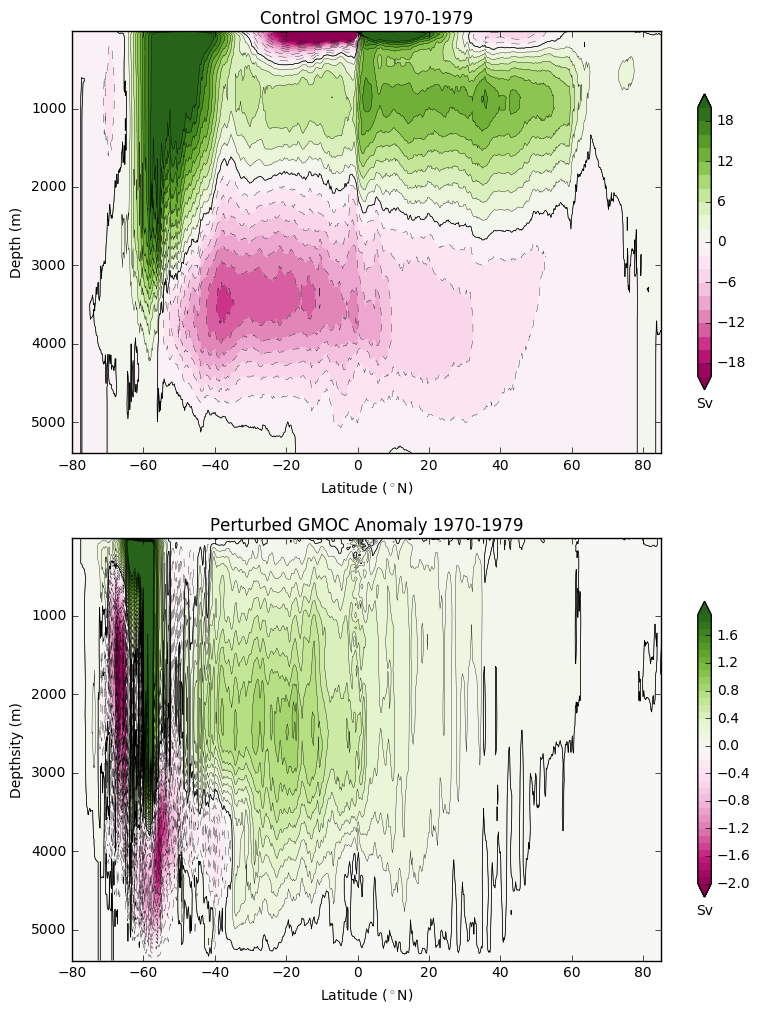

In [28]:
#Plot Gmoc in Z space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,22,2)

t1=0
t2=10

plt.subplot(211)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_gmoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_gmoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_gmoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-80,85])
tit='Control GMOC 1970-1979'
plt.title(tit)

clev = np.arange(-2,2,.1)

plt.subplot(212)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_gmoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_gmoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_gmoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depthsity (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-80,85])
tit='Perturbed GMOC Anomaly 1970-1979'
plt.title(tit)



In [28]:
## Calc the AMOC from ty_trans for forcing cases

(1080, 1440)
[-2 -1  0  1]


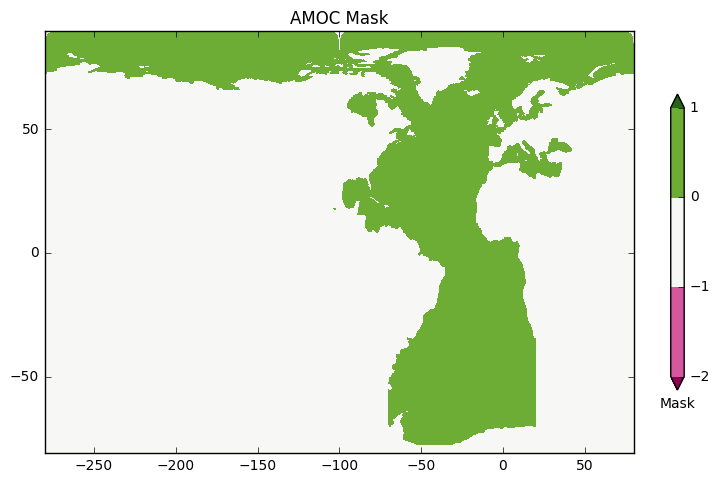

In [29]:
#calculate the AMOC mask
#-1 is Atl and Arctic, all other ocean is -2, land is 0
#reset to 1 and 0
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0
msk[np.where(msk==-1)]=1

clev = np.arange(-2,2,1)
print clev

plt.subplot(211)
plt.contourf(geolon_t,geolat_t,msk,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Mask')
plt.title('AMOC Mask')

In [30]:
#do AMOC in zspace
ff=xr.open_mfdataset('/g/data1/v45/pas561/mom/archive/wombat_jun16y_wedpoly/ty_trans.ann.nc',engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans.shape
ty=ff.ty_trans*msk
print ty.shape
amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()
print amoc.shape

of=os.path.join(Pert2Dir,'piwed_amoc_z.npy')
a=np.save(of,amoc)

(20, 50, 1080, 1440)
(20, 50, 1080, 1440)
(20, 50, 1080)


In [33]:
of=os.path.join(Pert2Dir,'piwed_amoc_z.npy')
pert_amoc_z=np.load(of)
print pert_amoc_z.shape


(20, 50, 1080)
(51, 50, 1080)


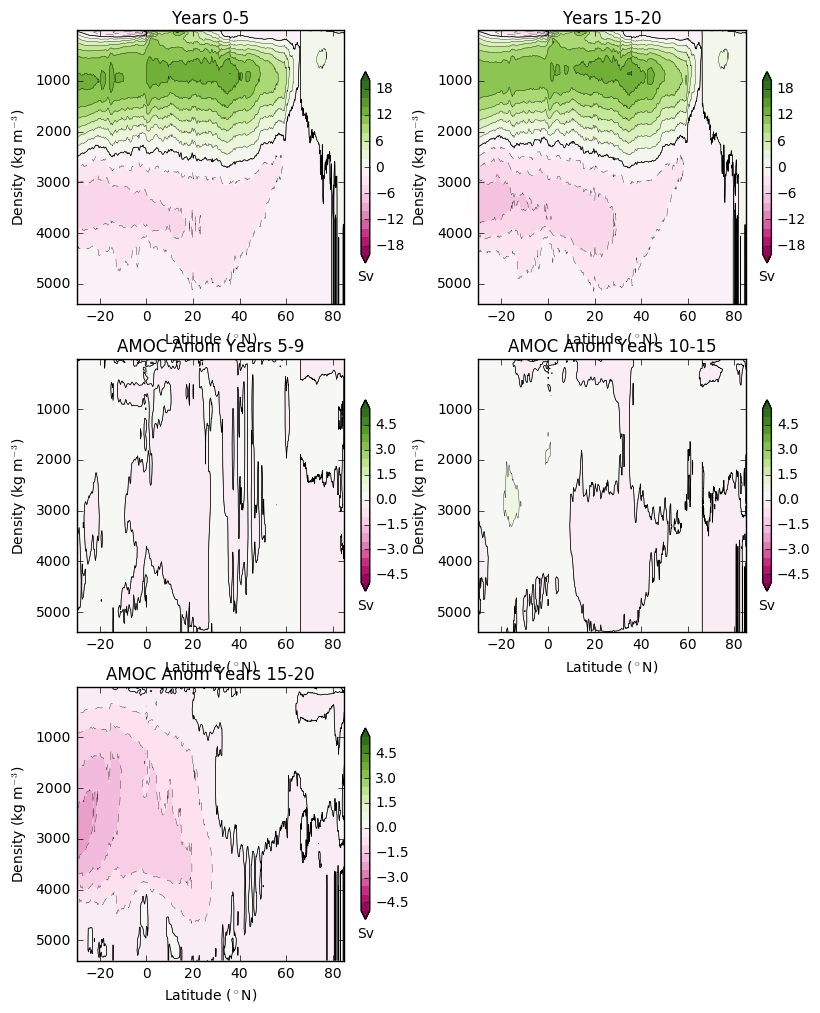

In [39]:
#Amoc in Z space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,22,2)

t1=0
t2=5

plt.subplot(321)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=15
t2=20

plt.subplot(322)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=5
t2=9

clev = np.arange(-5,6,.5)

plt.subplot(323)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=10
t2=15

plt.subplot(324)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=15
t2=20

plt.subplot(325)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(pert_amoc_z[0:5,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

(20,)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: converting an array with ndim > 0 to an

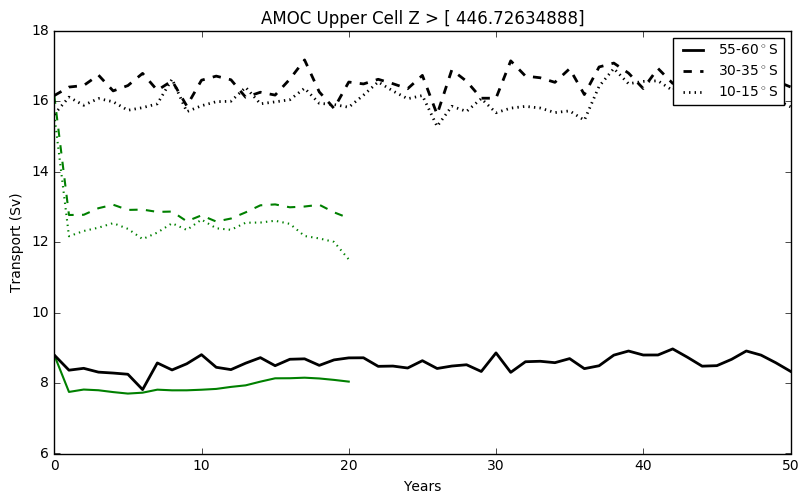

In [40]:
#plot time series of AMOC in z space
T=np.arange(20)
print T.shape


# do lower cell average between lats 55-60N
j1=np.argwhere(yt_ocean<55)
j2=np.argwhere(yt_ocean<60)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(st_ocean<500)
z1=z1[-1]

uc_cntrl50_psj = cntrl_amoc_z[:,z1:,j1:j2]
uc_cntrl50_psj_bar = np.mean(uc_cntrl50_psj,2)
uc_cntrl50_psj_ts = np.max(uc_cntrl50_psj_bar,1)

uc_pert50_psj = pert_amoc_z[:,z1:,j1:j2]
uc_pert50_psj_bar = np.mean(uc_pert50_psj,2)
uc_pert50_psj_ts = np.max(uc_pert50_psj_bar,1)
uc_pert50_psj_ts=np.insert(uc_pert50_psj_ts,0,uc_cntrl50_psj_ts[0])


# do lower cell average between lats 40-45N
j1=np.argwhere(yt_ocean<30)
j2=np.argwhere(yt_ocean<35)
j1=j1[-1]
j2=j2[-1]

uc_cntrl40_psj = cntrl_amoc_z[:,z1:,j1:j2]
uc_cntrl40_psj_bar = np.mean(uc_cntrl40_psj,2)
uc_cntrl40_psj_ts = np.max(uc_cntrl40_psj_bar,1)

uc_pert40_psj = pert_amoc_z[:,z1:,j1:j2]
uc_pert40_psj_bar = np.mean(uc_pert40_psj,2)
uc_pert40_psj_ts = np.max(uc_pert40_psj_bar,1)
uc_pert40_psj_ts=np.insert(uc_pert40_psj_ts,0,uc_cntrl40_psj_ts[0])

# do lower cell average between lats 20-25N
j1=np.argwhere(yt_ocean<10)
j2=np.argwhere(yt_ocean<15)
j1=j1[-1]
j2=j2[-1]

uc_cntrl20_psj = cntrl_amoc_z[:,z1:,j1:j2]
uc_cntrl20_psj_bar = np.mean(uc_cntrl20_psj,2)
uc_cntrl20_psj_ts = np.max(uc_cntrl20_psj_bar,1)

uc_pert20_psj = pert_amoc_z[:,z1:,j1:j2]
uc_pert20_psj_bar = np.mean(uc_pert20_psj,2)
uc_pert20_psj_ts = np.max(uc_pert20_psj_bar,1)
uc_pert20_psj_ts=np.insert(uc_pert20_psj_ts,0,uc_cntrl20_psj_ts[0])


plt.subplot(211)
plt.plot(uc_pert50_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(uc_cntrl50_psj_ts,linestyle='-',color='k',label='55-60$^\circ$N',linewidth=2)
plt.plot(uc_pert40_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(uc_cntrl40_psj_ts,linestyle='--',color='k',label='30-35$^\circ$N',linewidth=2)
plt.plot(uc_pert20_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(uc_cntrl20_psj_ts,linestyle=':',color='k',label='10-15$^\circ$N',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='AMOC Upper Cell Z > ' +str(st_ocean[z1])
plt.title(tit)
plt.legend(fontsize=10)

(15,)
[22]
(15, 50, 1080)
(15, 1080)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


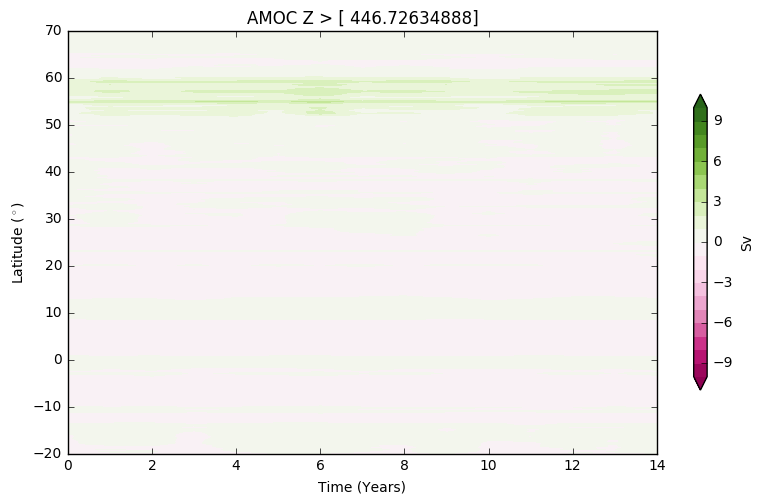

In [43]:
#AMOC Hovmoeller in Z space

t1=0
t2=15

time = np.arange(t1,t2,1)
print time.shape

st_min=np.argwhere(st_ocean<500)
st_min=st_min[-1]
print st_min

amoc_z_anom= pert_amoc_z[t1:t2,:,:] - cntrl_amoc_z[t1:t2,:,:]
print amoc_z_anom.shape

amoc_z_anom_max = np.max(amoc_z_anom[:,st_min:,:],1)
print amoc_z_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-10,10,21)
#print clev

plt.subplot(211)
plt.contourf(time,yu_ocean,amoc_z_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
tit='AMOC Z > ' +str(st_ocean[st_min])
plt.title(tit)

In [25]:
#north atl mld
Ocean_File = os.path.join('/g/data1/v45/APE-MOM/gfdl_nyf_1080_cp','output5*/ocean.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
cntrl_mld=ff.mld.load()
print cntrl_mld.shape


(51, 1080, 1440)


In [26]:

Ocean_File = os.path.join(PertDir,'output*/ocean.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
pert_mld=ff.mld.load()
print pert_mld.shape

(16, 1080, 1440)


In [52]:
ff=xr.open_mfdataset('/g/data1/v45/mtc599/mom5/jun16y/OUTPUT/ocean_surface_*.nc',engine='netcdf4',concat_dim='Time',decode_times=False)
print ff.mld_rho.shape
pert1_mld=ff.mld_rho[0:1825,:,:].mean('Time').load()
pert2_mld=ff.mld_rho[1825:3650,:,:].mean('Time').load()
pert3_mld=ff.mld_rho[3650:5475,:,:].mean('Time').load()
pert4_mld=ff.mld_rho[5475:7300,:,:].mean('Time').load()
print pert1_mld.shape


(7300, 1080, 1440)
(1080, 1440)


mld bounds lon1 lon2 lat1 lat2 [-99.875] [ 50.125] [ 30.13168517] 89.947282327


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


NameError: name 'pert1_mld' is not defined

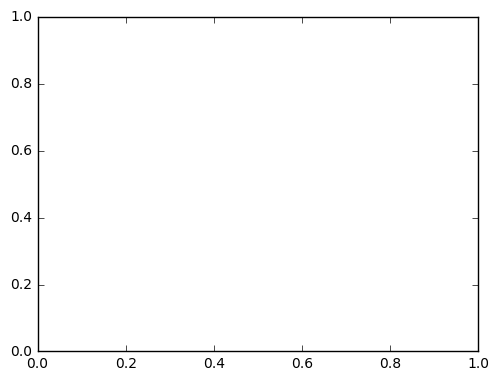

In [17]:
#plot mld
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>30)# and lat<-45)
jj2=np.argwhere(yt_ocean>80)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079
#jj2=jj2[0]

print "mld bounds lon1 lon2 lat1 lat2", xt_ocean[ii1], xt_ocean[ii2], yt_ocean[jj1], yt_ocean[jj2]

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

t1=0
t2=5
plt.subplot(221)#,axisbg='gray')
clev = np.arange(0,1200,100)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,pert1_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
#map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
#map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(a) Control')
#plt.show()

clev = np.arange(-200,210,10)
#clev2 = np.arange(-200,200,10)

t1=15
t2=20
plt.subplot(222)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,pert4_mld[jj1:jj2,ii1:ii2],cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
tit='(b) MLD Anom Years ' +str(t1+1) +'-' +str(t2)
plt.title(tit)
#plt.show()

t1=5
t2=10
plt.subplot(223)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,pert2_mld[jj1:jj2,ii1:ii2]-pert1_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
tit='(c) MLD Anom Years ' +str(t1+1) +'-' +str(t2)
plt.title(tit)

t1=10
t2=15
plt.subplot(224)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,pert3_mld[jj1:jj2,ii1:ii2]-pert1_mld[jj1:jj2,ii1:ii2], cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
tit='(d) MLD Anom Years ' +str(t1+1) +'-' +str(t2)
plt.title(tit)

plt.show()





In [24]:
print np.max(fh[540:1080,:])
print np.min(fh[540:1080,:])

3.59161e-06
4.91751e-09


In [32]:
#Hov of Sea Ice Conc. in Southern Ocean
print xt_ocean[1040]
print xt_ocean[878]

Ocean_File = os.path.join(CntrlDir,'output5*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
nyf_cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print nyf_cn.shape

Ocean_File = os.path.join(PertDir,'output*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
pert_cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print pert_cn.shape


-19.875
-60.375
(240, 5, 1080, 1440)
(240, 1080)
(192, 5, 1080, 1440)
(192, 1080)


(240, 1080)
(192, 1080)
(204, 1080)
(204,)
-19.875
-60.375
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


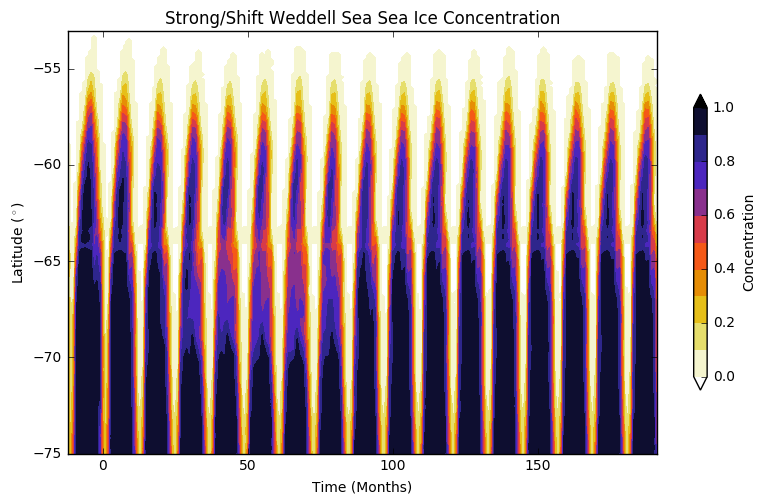

In [34]:
print nyf_cn.shape
print pert_cn.shape
cn = np.concatenate((nyf_cn[0:12,:],pert_cn),axis=0)
print cn.shape

time = np.arange(-12,192,1)
#print time
print time.shape

print xt_ocean[1040]
print xt_ocean[878]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(0,1.0,11)
print clev

plt.subplot(211)
plt.contourf(time,yt_ocean,cn.T,cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Concentration')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
#plt.xlim([-75,85])
plt.title('Strong/Shift Weddell Sea Sea Ice Concentration')